Start by downloading relevant data from the MICO competition, which can be found [here](https://codalab.lisn.upsaclay.fr/competitions/8551#participate-submit_results) (for CIFAR).

In [1]:
import os
import urllib

from torchvision.datasets.utils import download_and_extract_archive
from sklearn.metrics import roc_curve, roc_auc_score

from mico_competition.scoring import tpr_at_fpr, score, generate_roc, generate_table
from sklearn.metrics import roc_curve, roc_auc_score

import numpy as np
import torch
import csv
import copy

from torch.autograd import Variable
from sklearn import metrics
from tqdm.notebook import tqdm
from torch.distributions import normal
from torch.utils.data import DataLoader, Dataset
from mico_competition import ChallengeDataset, load_cifar10, load_model
from torch.distributions import Categorical
import torch.nn.utils.prune as prune

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import torch as ch
import torch.nn as nn

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn import tree
from scipy.stats import norm

import autosklearn.classification
import autosklearn.metrics

In [2]:
def normalize_preds(preds):
    """
        Function to normalize given predictions to [0, 1] scale.
    """
    # Normalize to unit interval
    min_prediction = np.min(preds)
    max_prediction = np.max(preds)
    preds = (preds - min_prediction) / (max_prediction - min_prediction)
    return preds

In [3]:
def get_class_scaled_logits(model, features, labels):
    """
        Use the approach described in LiRA (https://arxiv.org/abs/2112.03570) to use
        class-scaled logits instead of direct probabilities.
    """
    outputs = model(features).detach().cpu().numpy()
    num_classes = np.arange(outputs.shape[1])
    values = []
    for i, output in enumerate(outputs):
        label = labels[i].item()
        wanted = output[label]
        not_wanted = output[np.delete(num_classes, label)]
        values.append(wanted - np.max(not_wanted))
    return np.array(values)

In [4]:
@torch.no_grad()
def relative_log_merlin(model, features, labels):
    """
        Use the MERLIN (https://arxiv.org/abs/2005.10881) approach to sample neighbors and note
        variation in model loss. Modification uses log-scale while noting loss differences.
    """
    epsilon = 0.5
    small_value = 1e-10
    n_neighbors = 50
    criterion = torch.nn.CrossEntropyLoss(reduction='none')
    noise = normal.Normal(0, epsilon)
    diffs = []
    base_preds = model(features)
    base_losses = criterion(base_preds, labels).cpu().numpy()
    base_preds = base_preds.cpu().numpy()
    for i, feature in enumerate(features):
        neighbors = []
        distances = []
        for _ in range(n_neighbors):
            sampled_noise = noise.sample(feature.shape).to(feature.device)
            neighbors.append(feature + sampled_noise)
            distances.append(sampled_noise.mean().cpu().item())
        neighbors = torch.stack(neighbors, 0)
        loss_neighbors = criterion(model(neighbors), labels[i].view(1).repeat(n_neighbors))
        loss_change = ch.norm((loss_neighbors - base_losses[i])).item()
        # Use relative drop instead of absolute
        loss_change /= (small_value + base_losses[i].item())
        diffs.append(np.log(loss_change + small_value))
    diffs = np.array(diffs)
    # Clip at zero (lower side)
    diffs[diffs < 0] = 0
    return diffs

In [5]:
def ascent_recovery(model, features, labels, adv: bool = False):
    """
        Use gradient-ascent on the given data (and training loss) to make modifications to the input.
        Makes note of change in model loss after gradient ascent, as well as the change in the input itself.
        Idea: member would have less scope for loss reduction (and consequently smaller changes to the datum itself).
    """
    criterion = torch.nn.CrossEntropyLoss(reduction='none')
    n_times = 10
    step_size = 0.01 if adv else 0.1 # For normal, use higher
    final_losses, final_dist = [], []
    for i, (feature, label) in enumerate(zip(features, labels)):
        model.zero_grad()
        feature_var = Variable(feature.clone().detach(), requires_grad=True)
        for j in range(n_times):
            feature_var = Variable(feature_var.clone().detach(), requires_grad=True)
            loss = criterion(model(ch.unsqueeze(feature_var, 0)), torch.unsqueeze(label, 0))
            loss.backward(ch.ones_like(loss), retain_graph=True)
            with ch.no_grad():
                if adv:
                    feature_var.data += step_size * feature_var.data
                else:
                    feature_var.data -= step_size * feature_var.data
                loss_new = criterion(model(ch.unsqueeze(feature_var, 0)), ch.unsqueeze(label, 0))
        # Get reduction in loss
        final_losses.append(loss.item() - loss_new.item())
        # Get change in data (norm)
        final_dist.append(ch.norm(feature_var.data - feature.data).detach().cpu().numpy())
    final_losses = np.stack((final_losses, final_dist), 1)
    return final_losses.reshape(-1, 2)

In [6]:
def extended_epoch(model, features, labels, use_dp: bool = False):
    """
        "Train" model on given data to see how much loss changes.
        If was with DP, not seen many times (and with clipped gradient), so
        expected loss decrease would be much more than that for some point
        that has already been seen multiple times. While at it, also take note of gradient norms
        P.S I tried using the learning rates corresponding to different training mechanisms,
        turns out that using the same, higher LR, works out best in practice.
    """
    # 
    lr = 0.05 # if use_dp else 0.0005
    criterion = nn.CrossEntropyLoss(reduction='none')
    features_collected = []
    # Note losses currently
    base_preds = model(features).detach()
    base_losses = criterion(base_preds, labels).cpu().numpy()
    for i, (feature, label) in enumerate(zip(features, labels)):
        # Make copy of model
        model_ = copy.deepcopy(model)
        model_.train()
        model_.cuda()
        optimizer = ch.optim.SGD(model_.parameters(), lr=lr, momentum=0)
        optimizer.zero_grad()
        loss = criterion(model_(ch.unsqueeze(feature, 0)), ch.unsqueeze(label, 0))
        loss.backward()
        optimizer.step()
        # Keep track of gradient norms
        gradient_norms = [ch.linalg.norm(x.grad.detach().cpu()).item() for x in model_.parameters()]
        # Keep track of updated loss
        loss_new = criterion(model_(ch.unsqueeze(feature, 0)), ch.unsqueeze(label, 0)).detach().cpu().numpy()
        loss_difference = (base_losses[i] - loss_new).item()
        gradient_norms += [loss_difference]
        features_collected.append(gradient_norms)
    features_collected = np.array(features_collected)
    features_collected = features_collected.reshape(features_collected.shape[0], -1)
    # Do not care about biases or loss diff
    features_collected = features_collected[:, [0, 2, 4]]
    # features_collected = np.log(features_collected + 1e-10)
    return features_collected.reshape(features_collected.shape[0], -1)

In [7]:
def blind_walk(model, features, labels):
    """
        Inspired by dataset inference (https://arxiv.org/abs/2104.10706)
        Take fixed-size steps in random directions (but same random direction)
        and keep track of how many steps it takes to flip classification.
        Idea: members/non-members would have different proximity to decision boundaries
        and thus would have different statistics for this result.
    """
    # Track the number of steps taken until decision flips 
    # Walk no more than 100 steps, and try 10 different random directions
    num_directions = 10
    num_max_steps = 100
    point_of_failure = np.ones((num_directions, features.shape[0])) * np.inf
    std = 0.1
    for j in range(num_directions):
        noise = ch.randn_like(features) * std
        for i in range(1, num_max_steps + 1):
            new_labels = ch.argmax(model(features + noise * i).detach(), 1)
            flipped = np.nonzero((new_labels != labels).cpu().numpy())[0]
            point_of_failure[j][flipped] = np.minimum(point_of_failure[j][flipped], i)
    point_of_failure = np.clip(point_of_failure, 0, num_max_steps)
    point_of_failure = np.mean(point_of_failure, 0)
    return point_of_failure.reshape(-1, 1)

In [8]:
def custom_feature_collection(model, features, labels, use_dp: bool = False):
    """
        Collect all of the features described above. Also include an 'adv' variant for
        gradient-ascent that insted looks to maximize loss instead of minimizing it.
    """
    features_collected = []
    features_collected.append(ascent_recovery(model, features, labels))
    features_collected.append(ascent_recovery(model, features, labels, adv = True))
    features_collected.append(extended_epoch(model, features, labels, use_dp = use_dp))
    features_collected.append(relative_log_merlin(model, features, labels).reshape(-1, 1))
    features_collected.append(get_class_scaled_logits(model, features, labels).reshape(-1, 1))
    features_collected.append(blind_walk(model, features, labels).reshape(-1, 1))
    combined_feratures = np.concatenate(features_collected, 1)
    return combined_feratures

In [9]:
def matt_modified_scores(model, features, labels, model_reference):
    """
        MATT attack from https://arxiv.org/pdf/1908.11229.pdf
        Modified to adapt to the availability of auxiliary models.
        Works by comouting gradient alignment between the given model and another reference model.
        Idea: given the problem setup, any datapoint is more likely to be a member of a reference model
        than not being a member. This attack seeks to utilize this information by
        computing these alignment statistics over multiple reference models.
    """
    criterion = nn.CrossEntropyLoss(reduction='none')
    cos = nn.CosineSimilarity(dim=0)
    features_collected = []

    # Make copy of model
    model_ = copy.deepcopy(model)
    model_.cuda()

    for i, (feature, label) in enumerate(zip(features, labels)):
        # Compute gradients with both models
        model_.zero_grad()
        model_reference.zero_grad()
        loss = criterion(model_(ch.unsqueeze(feature, 0)), ch.unsqueeze(label, 0))
        loss_ref = criterion(model_reference(ch.unsqueeze(feature, 0)), ch.unsqueeze(label, 0))
        loss.backward()
        loss_ref.backward()
        
        # Compute product
        inner_features = []
        for p1, p2 in zip(model_.parameters(), model_reference.parameters()):
            term = ch.dot(p1.grad.detach().flatten(), p2.grad.detach().flatten()).item()
            inner_features.append(term)
        features_collected.append(inner_features)
    features_collected = np.array(features_collected)
    # Focus only on weight-related parameters
    features_collected = features_collected[:, [0, 2, 4, 6]]
    return features_collected

In [19]:
def extract_features_for_reference_models(reference_features):
    num_layers_collected = reference_features.shape[2]
    features = []
    for i in range(num_layers_collected):
        features.append((
            np.max(reference_features[:, :, i], 0) - np.min(reference_features[:, :,  i], 0),
            np.sum(np.abs(reference_features[:, :,  i]), 0),
            np.min(reference_features[:, :,  i], 0),
            np.max(reference_features[:, :,  i], 0)
        ))
    return np.concatenate(features, 0).T

In [14]:
def collect_models():
    """
        Collect all models from the 'train' set
    """
    CHALLENGE = "cifar10"
    LEN_TRAINING = 50000
    LEN_CHALLENGE = 100
    scenarios = os.listdir(CHALLENGE)

    dataset = load_cifar10(dataset_dir="/u/as9rw/work/MICO/data")

    collected_models = {x:[] for x in scenarios}
    phase = "train"
    for scenario in tqdm(scenarios, desc="scenario"):
        root = os.path.join(CHALLENGE, scenario, phase)
        for model_folder in tqdm(sorted(os.listdir(root), key=lambda d: int(d.split('_')[1])), desc="model"):
            path = os.path.join(root, model_folder)
            challenge_dataset = ChallengeDataset.from_path(path, dataset=dataset, len_training=LEN_TRAINING)
            challenge_points = challenge_dataset.get_challenges()
            
            model = load_model('cifar10', path)
            collected_models[scenario].append(model)

        collected_models[scenario] = np.array(collected_models[scenario], dtype=object)
            
    return collected_models

In [15]:
train_models = collect_models()

Files already downloaded and verified
Files already downloaded and verified


scenario:   0%|          | 0/3 [00:00<?, ?it/s]

model:   0%|          | 0/100 [00:00<?, ?it/s]

model:   0%|          | 0/100 [00:00<?, ?it/s]

model:   0%|          | 0/100 [00:00<?, ?it/s]

Feature vectors are a combination of two kinds of features. The first set (originating from `matt_modified_scores`) uses reference models and reference statistics between a given model and these reference models. The second set of features, originating from `custom_feature_collection`, does not use any additional reference models.

For Purchase100: without the reference-model-based features, the attack had a maximum TPR@0.1FPR of $\approx0.13$, and immediately jumped to $0.15$ with the inclusion of those reference-model-based features. Additional experimentation with the meta-classifier itself bumped performance further up to $>0.16$. My experience with these MI attacks has been that the choice of meta-classifier also matters. Most of the MI-related papers I looked at use LR-based models when dealing with features. It thus might be worthwhile to spend some time on feature engineering (using the same set of raw features) and meta-classifier optimization.

In [21]:
CHALLENGE = "cifar10"
scenarios = os.listdir(CHALLENGE)
phase = "train"
dataset = load_cifar10(dataset_dir="/u/as9rw/work/MICO/data")
LEN_TRAINING = 50000
LEN_CHALLENGE = 100

X_for_meta, Y_for_meta = {}, {}
num_use_others = 25 # 50 worked best, but too slow

# Check performance of approach on (1, n-1) models from train
for scenario in tqdm(scenarios, desc="scenario"):
    use_dp = not scenario.endswith('_inf')
    preds_all = []
    scores_all = []
    root = os.path.join(CHALLENGE, scenario, phase)
    all_except = np.arange(100)

    for i, model_folder in tqdm(enumerate(sorted(os.listdir(root), key=lambda d: int(d.split('_')[1]))), desc="model", total=100):
        path = os.path.join(root, model_folder)
        challenge_dataset = ChallengeDataset.from_path(path, dataset=dataset, len_training=LEN_TRAINING)
        challenge_points = challenge_dataset.get_challenges()
        
        challenge_dataloader = torch.utils.data.DataLoader(challenge_points, batch_size=2*LEN_CHALLENGE)
        features, labels = next(iter(challenge_dataloader))
        features, labels = features.cuda(), labels.cuda()
            
        model = load_model('cifar10', path)
        model.cuda()
        features, labels = features.cuda(), labels.cuda()
        # Look at all models except this one
        other_models = train_models[scenario][np.delete(all_except, i)]
        # Pick random models
        other_models = np.random.choice(other_models, num_use_others, replace=False)
        other_models = [x.cuda() for x in other_models]

        features_collected = np.array([matt_modified_scores(model, features, labels, other_model) for other_model in other_models])
        scores = extract_features_for_reference_models(features_collected)
        other_features = custom_feature_collection(model, features, labels, use_dp = use_dp)
        scores = np.concatenate((scores, other_features), 1)

        mem_labels = challenge_dataset.get_solutions()

        # Store
        preds_all.append(mem_labels)
        scores_all.append(scores)
    
    preds_all = np.concatenate(preds_all)
    scores_all = np.concatenate(scores_all)
    
    X_for_meta[scenario] = scores_all
    Y_for_meta[scenario] = preds_all

Files already downloaded and verified
Files already downloaded and verified


scenario:   0%|          | 0/3 [00:00<?, ?it/s]

model:   0%|          | 0/100 [00:00<?, ?it/s]

model:   0%|          | 0/100 [00:00<?, ?it/s]

model:   0%|          | 0/100 [00:00<?, ?it/s]

Use auto-sklearn (an automl package does does pipeline, optimizer, and hyper-param optimization for you) worked out best, second to using random-forest classifiers. In all scenarios, training classifiers separately for the different scenarios (no, low, high DP) worked better than training a single classifier, even when the scenario is explicitly provided as an input feature (one-hot encoding).

In [44]:
# Train different meta-classifiers per scenario
CHALLENGE = "cifar10"
scenarios = os.listdir(CHALLENGE)
meta_clfs = {x: autosklearn.classification.AutoSklearnClassifier(memory_limit=64 * 1024, time_left_for_this_task=180, metric=autosklearn.metrics.roc_auc) for ii, x in enumerate(X_for_meta.keys())}

avg = 0
use_all = False
for sc in scenarios:
    train_split_og, test_split_og = train_test_split(np.arange(100), test_size=20)
    train_split = np.concatenate([np.arange(200) + 200 * i for i in train_split_og])
    test_split = np.concatenate([np.arange(200) + 200 * i for i in test_split_og])
    if use_all:
        X_train = X_for_meta[sc]
        X_test  = X_for_meta[sc]
        y_train = Y_for_meta[sc]
        y_test  = Y_for_meta[sc]
    else:
        X_train = X_for_meta[sc][train_split]
        X_test  = X_for_meta[sc][test_split]
        y_train = Y_for_meta[sc][train_split]
        y_test  = Y_for_meta[sc][test_split]

    meta_clfs[sc].fit(X_train, y_train)
    preds = meta_clfs[sc].predict_proba(X_test)[:, 1]
    preds_train = meta_clfs[sc].predict_proba(X_train)[:, 1]
    
    print(f"{sc} AUC (train): {roc_auc_score(y_train, preds_train)}")
    scores = score(y_test, preds)
    scores.pop('fpr', None)
    scores.pop('tpr', None)
    display(pd.DataFrame([scores]))
    avg += scores['TPR_FPR_1000']

print("Average score", avg / 3)

[WARNING] [2023-01-31 09:30:49,787:Client-EnsembleBuilder] No runs were available to build an ensemble from
cifar10_hi AUC (train): 0.59659840625


,TPR_FPR_10,TPR_FPR_100,TPR_FPR_500,TPR_FPR_1000,TPR_FPR_1500,TPR_FPR_2000,AUC,MIA,accuracy
0,0.0,0.0125,0.061,0.146,0.204,0.257,0.560448,0.0895,0.54475


[WARNING] [2023-01-31 09:36:36,774:Client-EnsembleBuilder] No runs were available to build an ensemble from
cifar10_lo AUC (train): 0.5643315


,TPR_FPR_10,TPR_FPR_100,TPR_FPR_500,TPR_FPR_1000,TPR_FPR_1500,TPR_FPR_2000,AUC,MIA,accuracy
0,0.001,0.0155,0.058,0.106,0.1645,0.2145,0.527124,0.048,0.524


[WARNING] [2023-01-31 09:39:33,101:Client-EnsembleBuilder] No runs were available to build an ensemble from
cifar10_inf AUC (train): 0.6107555


,TPR_FPR_10,TPR_FPR_100,TPR_FPR_500,TPR_FPR_1000,TPR_FPR_1500,TPR_FPR_2000,AUC,MIA,accuracy
0,0.0005,0.022,0.087,0.1785,0.2395,0.2975,0.580789,0.117,0.5585


Average score 0.1435


For submissions, I set `use_all` to True (since the autoML classifier already does train-val splits internally). The train-test split above is just for visualization purposes (and to see how well the classifier performs on val data).

## Feature Inspection

A closer look (via permutation importance) at the features shows some interesting trends. First,the range of gradient alignment values across reference models seem to be most useful (as opposed to min, max, abs-sum). Features like LiRA and gradient norms in the extended-epoch simulation also seem to be important.

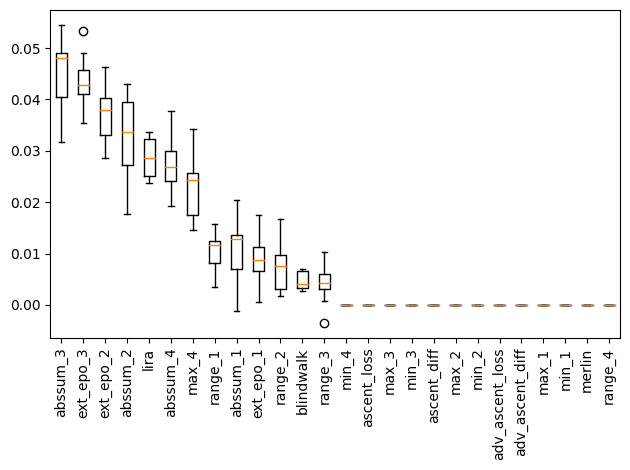

[12] range_4   : 0.000 +/- 0.000
[23] merlin    : 0.000 +/- 0.000
[2] min_1     : 0.000 +/- 0.000
[3] max_1     : 0.000 +/- 0.000
[19] adv_ascent_diff: 0.000 +/- 0.000
[18] adv_ascent_loss: 0.000 +/- 0.000
[6] min_2     : 0.000 +/- 0.000
[7] max_2     : 0.000 +/- 0.000
[17] ascent_diff: 0.000 +/- 0.000
[10] min_3     : 0.000 +/- 0.000
[11] max_3     : 0.000 +/- 0.000
[16] ascent_loss: 0.000 +/- 0.000
[14] min_4     : 0.000 +/- 0.000
[8] range_3   : 0.004 +/- 0.004
[25] blindwalk : 0.005 +/- 0.002
[4] range_2   : 0.008 +/- 0.005
[20] ext_epo_1 : 0.009 +/- 0.005
[1] abssum_1  : 0.011 +/- 0.006
[0] range_1   : 0.011 +/- 0.004
[15] max_4     : 0.023 +/- 0.006
[13] abssum_4  : 0.027 +/- 0.005
[24] lira      : 0.029 +/- 0.004
[5] abssum_2  : 0.032 +/- 0.008
[21] ext_epo_2 : 0.037 +/- 0.005
[22] ext_epo_3 : 0.044 +/- 0.005
[9] abssum_3  : 0.045 +/- 0.007


In [52]:
from sklearn.inspection import plot_partial_dependence, permutation_importance

r = permutation_importance(meta_clfs["cifar10_inf"], X_test, y_test, n_repeats=10, random_state=0)
sort_idx = r.importances_mean.argsort()[::-1]

labels = []
for i in range(4):
    labels.append(f"range_{i+1}")
    labels.append(f"abssum_{i+1}")
    labels.append(f"min_{i+1}")
    labels.append(f"max_{i+1}")
labels.append("ascent_loss")
labels.append("ascent_diff")
labels.append("adv_ascent_loss")
labels.append("adv_ascent_diff")
labels.append("ext_epo_1")
labels.append("ext_epo_2")
labels.append("ext_epo_3")
labels.append("merlin")
labels.append("lira")
labels.append("blindwalk")

plt.boxplot(
    r.importances[sort_idx].T, labels=[labels[i] for i in sort_idx]
)
    
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

for i in sort_idx[::-1]:
    print(
        f"[{i}] {labels[i]:10s}: {r.importances_mean[i]:.3f} +/- "
        f"{r.importances_std[i]:.3f}"
    )

## Collect features

Collect features for all models across scenarios and phases. Helps to re-use features when experiment with different meta-classifiers. No need to re-run for 'train' models, since we already have features for those.

In [ ]:
CHALLENGE = "cifar10"
LEN_TRAINING = 50000
LEN_CHALLENGE = 100

scenarios = os.listdir(CHALLENGE)
phases = ['dev', 'final']
stored_features = {}

dataset = load_cifar10(dataset_dir="/u/as9rw/work/MICO/data")

for i, scenario in tqdm(enumerate(scenarios), desc="scenario", total=3):
    use_dp = not scenario.endswith('_inf')
    stored_features[scenario] = {}
    for phase in tqdm(phases, desc="phase"):
        stored_features[scenario][phase] = []
        root = os.path.join(CHALLENGE, scenario, phase)
        all_except = np.arange(100)
        for j, model_folder in tqdm(enumerate(sorted(os.listdir(root), key=lambda d: int(d.split('_')[1]))), desc="model", total=len(os.listdir(root))):
            path = os.path.join(root, model_folder)
            challenge_dataset = ChallengeDataset.from_path(path, dataset=dataset, len_training=LEN_TRAINING)
            challenge_points = challenge_dataset.get_challenges()
            
            model = load_model('cifar10', path)
            challenge_dataloader = torch.utils.data.DataLoader(challenge_points, batch_size=2*LEN_CHALLENGE)
            features, labels = next(iter(challenge_dataloader))

            model.cuda()
            features, labels = features.cuda(), labels.cuda()
            # Look at all models except this one
            other_models = train_models[scenario][np.delete(all_except, j)]
            other_models = np.random.choice(other_models, num_use_others, replace=False)
            features_collected = np.array([matt_modified_scores(model, features, labels, other_model.cuda()) for other_model in other_models])
            scores = extract_features_for_reference_models(features_collected)
            other_features = custom_feature_collection(model, features, labels, use_dp=use_dp)
            processed_features = np.concatenate((scores, other_features), 1)

            stored_features[scenario][phase].append(processed_features)

## Generate Predictions

In [ ]:
CHALLENGE = "cifar10"
LEN_TRAINING = 50000
LEN_CHALLENGE = 100

scenarios = os.listdir(CHALLENGE)
phases = ['dev', 'final']

dataset = load_cifar10(dataset_dir="/u/as9rw/work/MICO/data")

for i, scenario in tqdm(enumerate(scenarios), desc="scenario", total=3):
    for phase in tqdm(phases, desc="phase"):
        root = os.path.join(CHALLENGE, scenario, phase)
        j = 0
        for model_folder in tqdm(sorted(os.listdir(root), key=lambda d: int(d.split('_')[1])), desc="model"):
            path = os.path.join(root, model_folder)
            features_use = stored_features[scenario][phase][j]
            # Using scenario-wise meta-classifier
            predictions = meta_clfs[scenario].predict_proba(features_use)[:, 1]
            j += 1
            assert np.all((0 <= predictions) & (predictions <= 1))

            with open(os.path.join(path, "prediction.csv"), "w") as f:
                 csv.writer(f).writerow(predictions)

## Packaging the submission

Now we can store the predictions into a zip file, which you can submit to CodaLab.

In [ ]:
import zipfile

phases = ['dev', 'final']
experiment_name = "final_submission"

with zipfile.ZipFile(f"submissions_cifar/{experiment_name}.zip", 'w') as zipf:
    for scenario in tqdm(scenarios, desc="scenario"): 
        for phase in tqdm(phases, desc="phase"):
            root = os.path.join(CHALLENGE, scenario, phase)
            for model_folder in tqdm(sorted(os.listdir(root), key=lambda d: int(d.split('_')[1])), desc="model"):
                path = os.path.join(root, model_folder)
                file = os.path.join(path, "prediction.csv")
                if os.path.exists(file):
                    zipf.write(file)
                else:
                    raise FileNotFoundError(f"`prediction.csv` not found in {path}. You need to provide predictions for all challenges")